# Portofolio:

## Business Understanding

### Introduction

A fitness center offers comprehensive facilities and training programs to help customers achieve their fitness goals. Currently, they are running an attractive promotional program by offering a 99% discount on the first month's membership fee for new sign-ups. The aims of this coupon program is to:
- increase member growth
- increase long term profit
- build a loyal customer

The marketing team wants to know customer lifetime value by understanding how long customers will stop visiting the fitness center using the survival analysis methodology. Churn is a tricky case. Although we say the customer is a churn already, there is still a chance to win back even old customers. Our marketing team definition for churn is if customers don't visit the fitness center in last six months, they assume that the customers are churn. It means, churn is for customers that don't visit for more than six months and not churn is for customers that still visit in last six months.

Information we need to know:
- subscription price: IDR 199.000
- gross profit: 55%
- first month discount: 99%

### Objectives

The aim of this project is to understand:
- the customers behaviour after signup and using their 99% discount on the first month membership,
- how long customer will survive from churn,
- how much is the customer acquisition cost without ads,
- what is the customer lifetime value, and
- what factors influence the duration of survival.

### Tools and Dataset Needed

The technologies used for this project is Python with its library such as numpy, pandas, matplotlib, seaborn, and lifeliness. The dataset contains few variables like customer_id, first_visit, last_visit, and age.

### Methodology

The survival analysis has some steps to do. All variables we need are time to event where this variable explains how long until the event occurs, target variable where this variable explains whether or not the event occurs until the study ends (it's called right cencored), and other variables that has correlation with the target.

We'll make churn variable by using if logic. 1 if last_visit < (query_time - six months) else 0 where 1 is churn and 0 is not churn.

the CLTV formula:

$$CLTV = {Total \ GP \over Customers}$$

$$Total \ GP = {Transaction * Price * Gross \ Profit * Average \ Lifetime} $$

Where:
- Transaction means customers pays the bill (counted per each month)
- Price is the subscription price
- Gross Profit is a profit after all expenses
- Average Lifetime is the average duration before they do churn.

In [27]:
7*199000*0.55

766150.0000000001

## Data Understanding

### Data Acquisition

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines

In [2]:
dataset = pd.read_csv('data/fitness_10-2024.csv')
dataset.head()

,customer_id,register_date,last_visit,age
0,1001,2023-09-29,2023-10-21,27
1,1007,2023-11-28,2023-12-19,35
2,1011,2024-02-25,2024-03-20,28
3,1012,2023-07-30,2023-08-23,22
4,1033,2023-10-03,2023-10-22,29


### Data Profiling

In [3]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    1476 non-null   int64 
 1   register_date  1476 non-null   object
 2   last_visit     1476 non-null   object
 3   age            1476 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.3+ KB


The register_date and last_visit are still object type, so we will correct it later.

In [4]:
# missing values
dataset.isnull().sum()

customer_id      0
register_date    0
last_visit       0
age              0
dtype: int64

In [5]:
# duplicated values
dataset.duplicated().sum()

0

In [6]:
# correct wrong format
dataset['register_date'] = pd.to_datetime(dataset['register_date'])
dataset['last_visit'] = pd.to_datetime(dataset['last_visit'])

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    1476 non-null   int64         
 1   register_date  1476 non-null   datetime64[ns]
 2   last_visit     1476 non-null   datetime64[ns]
 3   age            1476 non-null   int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 46.3 KB


Now we can see that the register_date and last_visit are already datetime type.

### Descriptive Statistics

In [8]:
dataset['register_date'].value_counts()

register_date
2023-03-24    12
2023-05-28    11
2023-07-30    11
2023-05-31    11
2023-04-24    11
              ..
2023-05-29     1
2024-01-09     1
2023-01-17     1
2023-10-24     1
2023-01-03     1
Name: count, Length: 418, dtype: int64

In [9]:
dataset['last_visit'].value_counts()

last_visit
2023-12-27    15
2024-08-25     9
2024-09-15     9
2024-09-08     9
2024-09-23     8
              ..
2023-08-18     1
2024-03-09     1
2023-09-28     1
2024-01-15     1
2024-04-29     1
Name: count, Length: 416, dtype: int64

In [10]:
dataset[['register_date','last_visit','age']].describe(include='all').round(3)

,register_date,last_visit,age
count,1476,1476,1476.000
mean,2023-07-03 17:11:13.170732032,2024-03-05 01:28:46.829268224,31.498
min,2022-11-07 00:00:00,2023-08-02 00:00:00,19.000
25%,2023-04-22 18:00:00,2023-11-24 00:00:00,28.000
50%,2023-07-03 00:00:00,2024-03-05 00:00:00,31.000
75%,2023-09-07 00:00:00,2024-06-23 00:00:00,35.000
max,2024-03-09 00:00:00,2024-10-01 00:00:00,48.000
std,NaN,NaN,4.927


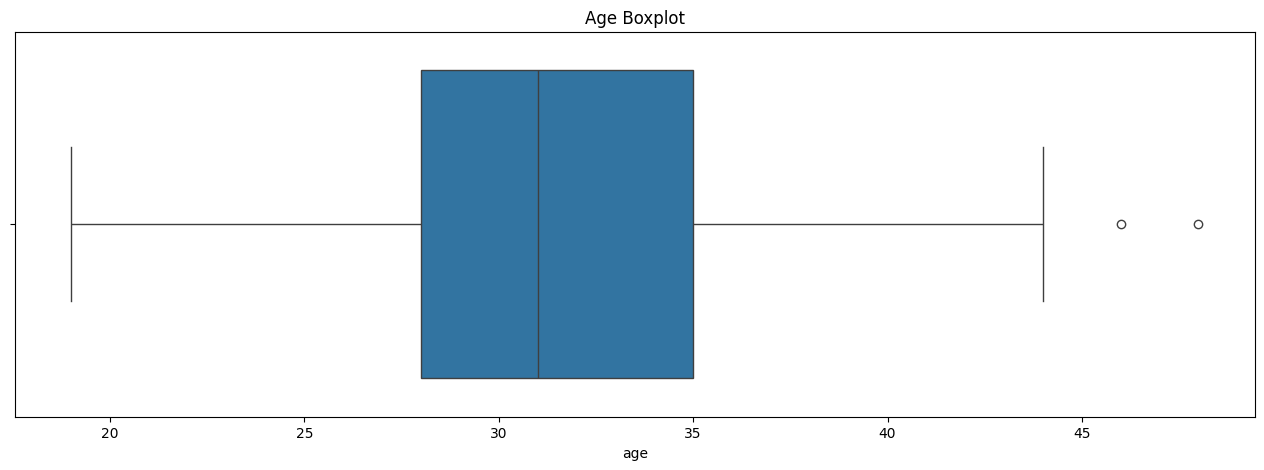

In [11]:
plt.figure(figsize=(16,5))
sns.boxplot(dataset, x='age')
plt.title('Age Boxplot')
plt.show()

In [12]:
# check independent sample
for i in dataset['customer_id'].value_counts():
    if i > 1:
        print('not independent sample detected')
        break

The sample are independent and not counted twice.

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    1476 non-null   int64         
 1   register_date  1476 non-null   datetime64[ns]
 2   last_visit     1476 non-null   datetime64[ns]
 3   age            1476 non-null   int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 46.3 KB


## Data Preprocessing

In [14]:
dataset['duration'] = (pd.Series(dataset['last_visit']-dataset['register_date']).dt.days/30).astype('int')
dataset.head()

,customer_id,register_date,last_visit,age,duration
0,1001,2023-09-29,2023-10-21,27,0
1,1007,2023-11-28,2023-12-19,35,0
2,1011,2024-02-25,2024-03-20,28,0
3,1012,2023-07-30,2023-08-23,22,0
4,1033,2023-10-03,2023-10-22,29,0


To get duration, we need to subtrack the last_visit with register_date. Some people go to the fitness center once a week, twice a week, or even everyday. We count just one for both who visit everyday and once a week.

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    1476 non-null   int64         
 1   register_date  1476 non-null   datetime64[ns]
 2   last_visit     1476 non-null   datetime64[ns]
 3   age            1476 non-null   int64         
 4   duration       1476 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(2)
memory usage: 52.0 KB


In [16]:
dataset.describe()

,customer_id,register_date,last_visit,age,duration
count,1476.000000,1476,1476,1476.000000,1476.000000
mean,1738.500000,2023-07-03 17:11:13.170732032,2024-03-05 01:28:46.829268224,31.497967,7.644986
min,1001.000000,2022-11-07 00:00:00,2023-08-02 00:00:00,19.000000,0.000000
25%,1369.750000,2023-04-22 18:00:00,2023-11-24 00:00:00,28.000000,4.000000
50%,1738.500000,2023-07-03 00:00:00,2024-03-05 00:00:00,31.000000,7.000000
75%,2107.250000,2023-09-07 00:00:00,2024-06-23 00:00:00,35.000000,13.000000
max,2476.000000,2024-03-09 00:00:00,2024-10-01 00:00:00,48.000000,19.000000
std,426.228812,NaN,NaN,4.926923,5.336156


We query the dataset on '2024-10-01'. So, the churn statement point is '2024-04-01'. Last visit before churn statement point will count as churn.

In [17]:
def churn(x):
    if pd.Timestamp(x) < pd.Timestamp('2024-04-01'):
        return 1
    else:
        return 0

In [18]:
dataset['churn'] = dataset['last_visit'].apply(churn)
dataset

,customer_id,register_date,last_visit,age,duration,churn
0,1001,2023-09-29,2023-10-21,27,0,1
1,1007,2023-11-28,2023-12-19,35,0,1
2,1011,2024-02-25,2024-03-20,28,0,1
3,1012,2023-07-30,2023-08-23,22,0,1
4,1033,2023-10-03,2023-10-22,29,0,1
...,...,...,...,...,...,...
1471,2462,2023-06-10,2024-08-21,33,14,0
1472,2465,2022-12-29,2024-05-11,41,16,0
1473,2467,2023-07-27,2024-09-14,39,13,0
1474,2473,2023-02-13,2024-04-02,40,13,0


In [19]:
dataset_clean = dataset[['age','duration','churn']].copy()

## Modeling

In [20]:
kmf = lifelines.KaplanMeierFitter()

In [21]:
kmf.fit(durations=dataset_clean['duration'],
        event_observed=dataset_clean['churn'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1476 total observations, 645 right-censored observations>

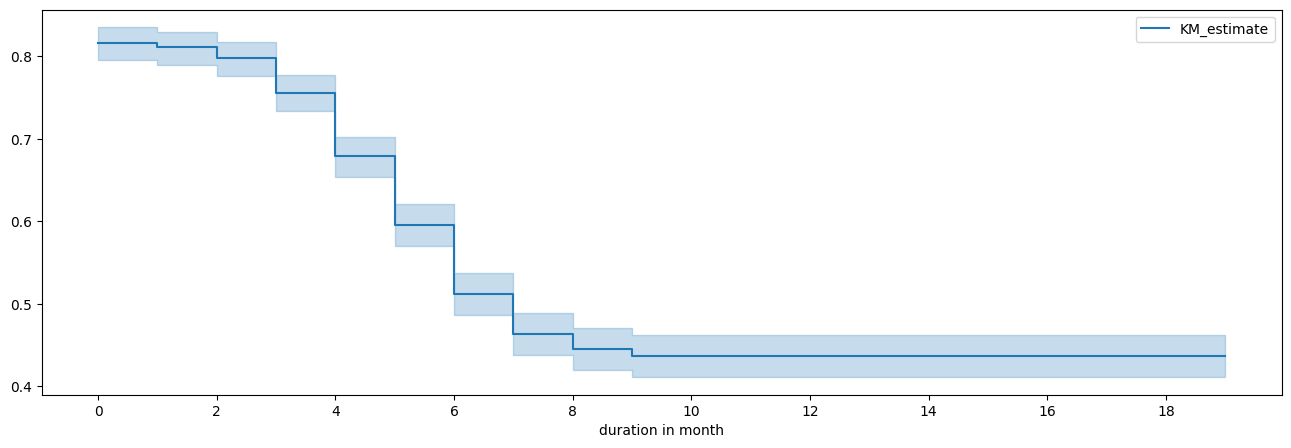

In [23]:
plt.figure(figsize=(16,5))
kmf.plot()
plt.xticks(np.arange(0, dataset_clean['duration'].max()+1,step=2))
plt.xlabel('duration in month')
plt.show()

In [34]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,271,271,0,1476,1476
1.0,8,8,0,0,1205
2.0,20,19,1,0,1197
3.0,62,62,0,0,1177
4.0,114,114,0,0,1115
5.0,122,122,0,0,1001
6.0,124,124,0,0,879
7.0,73,71,2,0,755
8.0,27,27,0,0,682


## Insights

### Interpretation and Reporting

### Action